In [ ]:
""" BLOCK 1: SAMPLE TRAINING DATA """
import os, glob, re, shutil
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from datetime import datetime
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import box, mapping
from tqdm import tqdm
import xml.etree.ElementTree as ET
import pyarrow.parquet as pq
import pyarrow as pa
from numba import njit

# Numba Helper for Quick Processing
@njit(parallel=True, fastmath=True)
def valid_mask_from_udm2(udm2, clear_idx=1):
    """
    Returns True for clear pixels using UDM2.
    UDM2 band 1 = 'Clear' (0 or 1)
    """
    mask = np.zeros(udm2.shape[1:], dtype=np.bool_)
    h, w = udm2.shape[1], udm2.shape[2]
    for i in range(h):
        for j in range(w):
            if udm2[clear_idx-1, i, j] == 1:
                mask[i, j] = True
    return mask

def sample_valid_pixels(valid_mask, n, seed=None):
    """Randomly sample n valid pixel coordinates"""
    if seed is not None:
        np.random.seed(seed)
    ys, xs = np.nonzero(valid_mask)
    if len(ys) == 0:
        return np.empty(0, dtype=np.int64), np.empty(0, dtype=np.int64)
    if n >= len(ys):
        return ys, xs
    idx = np.random.choice(len(ys), size=n, replace=False)
    return ys[idx], xs[idx]

# Planet XML Parser
def parse_planet_xml(xml_path):
    """Extracts basic metadata from a PlanetScope product XML."""
    
    # Default dictionary to prevent returning None
    meta = {
        "latitude": np.nan,
        "longitude": np.nan,
        "DOY": np.nan,
        "orbitDirection": np.nan,
        "incidenceAngle": np.nan,
        "illuminationAzimuthAngle": np.nan,
        "illuminationElevationAngle": np.nan,
        "azimuthAngle": np.nan,
        "spaceCraftViewAngle": np.nan
    }

    if not os.path.exists(xml_path):
        return meta

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing XML {xml_path}: {e}")
        return meta

    # Collect declared namespaces in case tag lookup requires them
    ns = {}
    for _, (prefix, uri) in ET.iterparse(xml_path, events=['start-ns']):
        ns[prefix] = uri

    ns.setdefault('ps',   'http://schemas.planet.com/ps/v1/planet_product_metadata_geocorrected_level')
    ns.setdefault('eop',  'http://earth.esa.int/eop')
    ns.setdefault('opt',  'http://earth.esa.int/opt')
    ns.setdefault('gml',  'http://www.opengis.net/gml')

    # Helper to find text for a local name (ignore or respect namespace)
    def find_text(tag):
        """Try both with and without namespace"""
        try:
            el = root.find(f".//{tag}", ns)
            if el is not None and el.text:
                return el.text.strip()
        except Exception:
            pass
        # Fallback: ignore namespace and match by localname suffix
        for el in root.iter():
            if el.tag.endswith(tag.split(':')[-1]) and el.text:
                return el.text.strip()
        return None

    # Coordinates: use the first latitude/longitude pair (topLeft)
    lat_txt = find_text("ps:latitude")
    lon_txt = find_text("ps:longitude")
    if lat_txt and lon_txt:
        try:
            meta["latitude"] = float(lat_txt)
            meta["longitude"] = float(lon_txt)
        except ValueError:
            pass

    # Acquisition date/time (ps:acquisitionDateTime or gml:beginPosition)
    acq_time = find_text("ps:acquisitionDateTime") or find_text("gml:beginPosition")
    if acq_time:
        try:
            dt = datetime.fromisoformat(acq_time.replace("Z", "+00:00"))
            meta["DOY"] = dt.timetuple().tm_yday
        except Exception:
            pass

    # Angles and orbit data
    tag_map = {
        "eop:orbitDirection": "orbitDirection",
        "eop:incidenceAngle": "incidenceAngle",
        "opt:illuminationAzimuthAngle": "illuminationAzimuthAngle",
        "opt:illuminationElevationAngle": "illuminationElevationAngle",
        "ps:azimuthAngle": "azimuthAngle",
        "ps:spaceCraftViewAngle": "spaceCraftViewAngle"
    }

    for tag, key in tag_map.items():
        val = find_text(tag)
        if val:
            try:
                meta[key] = float(val)
            except ValueError:
                meta[key] = val

    return meta

# Main function for image sampling
def generate_planet_training_parquet(base_dir, study_site, lake_shp, out_training_path, num_samples_per_lake=5, epsg=32606):
    """
    Build a parquet training set of PlanetScope pixels sampled from 'ICE' and 'WATER' folders.
    Each lake polygon is sampled randomly within valid (clear) pixels from UDM2 mask.
    """

    site_dir = os.path.join(base_dir, study_site)
    class_folders = {
        "ice": os.path.join(site_dir, "_ICE"),
        "water": os.path.join(site_dir, "_WATER")
    }

    records = []
    for label, fdir in class_folders.items():
        # only include analytic image TIFFs, skip UDM and masks
        for tif in glob.glob(os.path.join(fdir, "*.tif")):
            fname = os.path.basename(tif).lower()
            if "udm" in fname or "mask" in fname or "visual" in fname:
                continue
            records.append({"scene_path": tif, "class": label})

    df_class = pd.DataFrame(records)

    print(f"Loaded {len(df_class)} samples ({df_class['class'].value_counts().to_dict()})")

    # Load lake polygons as gdf
    gdf_lakes = gpd.read_file(lake_shp).to_crs(epsg=epsg)

    all_samples = []

    # Process each Planet image to find all associated files
    for _, rec in tqdm(df_class.iterrows(), total=len(df_class), desc="Processing scenes"):
        img_path = rec["scene_path"]
        label = rec["class"]
        folder = os.path.dirname(img_path)
        fname = os.path.basename(img_path)

        # Derive base name (remove analytic/sr suffixes)
        base_name = re.sub(r'(_analytic.*)?\.tif$', '', fname, flags=re.IGNORECASE)

        xml_path = os.path.join(folder, base_name + ".xml")
        xml_alt1 = os.path.join(folder, base_name + "_analytic_4b_xml.xml")
        xml_alt2 = os.path.join(folder, base_name + "_analytic_xml.xml")
        for alt in [xml_alt1, xml_alt2]:
            if not os.path.exists(xml_path) and os.path.exists(alt):
                xml_path = alt

        # UDM2 must exist for the analytic file
        udm_path = os.path.join(folder, base_name + "_udm2.tif")
        if not os.path.exists(udm_path):
            print(f"No UDM2 for {base_name}, skip.")
            continue

        # Parse XML
        xml_meta = parse_planet_xml(xml_path)
        if xml_meta is None:
            xml_meta = {}

        # Load SR image
        with rasterio.open(img_path) as src_analytic:
            analytic = src_analytic.read()  # shape (4, H, W)
            transform = src_analytic.transform
            height, width = src_analytic.height, src_analytic.width

        band_names = [f"band{i+1}" for i in range(analytic.shape[0])]

        # Derive cloud mask (shouldn't be necessary because we limit to 0% cloud, but occasionally a small number of pixels seem to slip through)
        with rasterio.open(udm_path) as src_udm:
            udm2 = src_udm.read()
        valid_mask = valid_mask_from_udm2(udm2)

   
        # Sample from lake polygons
        raster_bounds = box(*rasterio.transform.array_bounds(height, width, transform))
        lakes_in_scene = gdf_lakes[gdf_lakes.intersects(raster_bounds)]
        if lakes_in_scene.empty:
            continue

        geoms = [
            mapping(l.geometry.intersection(raster_bounds))
            for _, l in lakes_in_scene.iterrows() if not l.geometry.is_empty
        ]
        lake_mask = ~geometry_mask(
            geoms,
            transform=transform,
            invert=True,
            out_shape=(height, width)
        )

        combined_mask = valid_mask & lake_mask

        # Random sampling
        total_samples = num_samples_per_lake * len(geoms)
        ys, xs = sample_valid_pixels(combined_mask, total_samples, seed=42)
        if len(ys) == 0:
            continue

        sample_records = []
        for y, x in zip(ys, xs):
            # Pixel values for each band
            sdict = {band_names[b]: float(analytic[b, y, x])
                     for b in range(analytic.shape[0])}
            sdict.update({
                "scene": base_name,
                "label": label,
                "row": int(y),
                "col": int(x)
            })
            sdict.update(xml_meta)
            sample_records.append(sdict)

        if sample_records:
            all_samples.append(pd.DataFrame(sample_records))

    # Save / Output
    if not all_samples:
        print("No samples generated after filtering.")
        return

    df_all = pd.concat(all_samples, ignore_index=True)
    os.makedirs(os.path.dirname(out_training_path), exist_ok=True)
    pq.write_table(pa.Table.from_pandas(df_all), out_training_path)

    print(f"\nSaved {len(df_all)} Planet training samples to {out_training_path}")
    print("Columns:", list(df_all.columns))

# Run code below:
output_path = r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Planet Samples for RF\Models\YF_Freezeup\YF_planet_training.parquet"

generate_planet_training_parquet(
    base_dir=r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Planet Samples for RF",
    study_site="YF",
    lake_shp=r"E:\planetscope_lake_ice\Data\Input\Study Sites - Manual ALPOD Data\YF 50x50 km\YF Lakes from ALPOD Shapefile\YF_50x50km_lakes.shp",
    out_training_path=output_path,
    num_samples_per_lake=12,
    epsg=32606
)


Classes: ['ice', 'water'] -> [0, 1]

Splitting data: 80% train, 20% test...
Training samples: 76636
Test samples: 19160
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:
  max_depth: None
  max_features: sqrt
  min_samples_split: 5
  n_estimators: 400

Best CV accuracy: 0.9034
Best model CV train accuracy: 0.9936
Best model CV val accuracy: 0.9034
Classification Report (Test):
              precision    recall  f1-score   support

         ice       0.93      0.87      0.90      9984
       water       0.87      0.93      0.90      9176

    accuracy                           0.90     19160
   macro avg       0.90      0.90      0.90     19160
weighted avg       0.90      0.90      0.90     19160



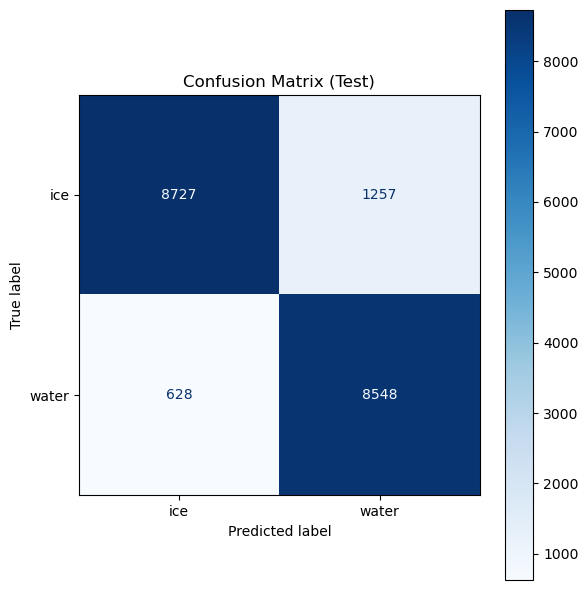

Final model trained

Feature importances (sorted):
1. band1     : 0.5237
2. band2     : 0.2281
3. band3     : 0.1352
4. band4     : 0.1130

Feature importance plot saved


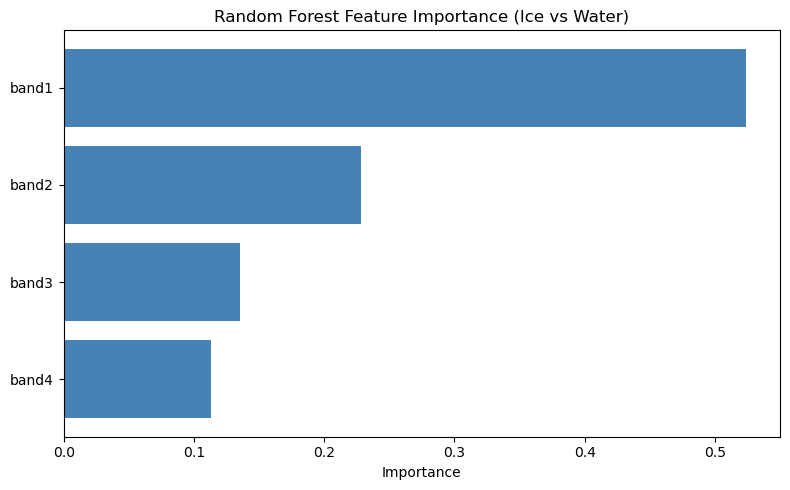

Feature importances exported to: E:\planetscope_lake_ice\Data\Input\Machine Learning - Planet Samples for RF\Models\YF_Freezeup\YF_planet_training_feature_importance.csv
model package saved to: E:\planetscope_lake_ice\Data\Input\Machine Learning - Planet Samples for RF\Models\YF_Freezeup\YF_planet_training_RFmodel.joblib


In [2]:
""" BLOCK 2: TRAIN AND EVALUATE RANDOM FOREST W/ CV HYPERPARAMETER TUNING"""
import pyarrow.parquet as pq
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# input filepaths
base_dir = r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Planet Samples for RF"
parquet_path = os.path.join(r"E:\planetscope_lake_ice\Data\Input\Machine Learning - Planet Samples for RF\Models\YF_Freezeup\YF_planet_training.parquet")
model_out_path = parquet_path.replace(".parquet", "_RFmodel.joblib")
test_size = 0.2  # Hold out 20% for final testing
random_state = 42

# load data
df = pq.read_table(parquet_path).to_pandas()

# drop unusable columns (view angle was controlling entirely due to limited number of input images, but should be removed for full workflow)
drop_cols = {
    "scene", "label", "row", "col",
    "orbitDirection", "DOY",
    "illuminationElevationAngle", "illuminationAzimuthAngle",
    "spaceCraftViewAngle", "incidenceAngle",
    "latitude", "longitude", "azimuthAngle"
}

# drop non-feature columns to exclude from RF
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].astype(float)

# encode text labels ("ice"/"water") 
le = LabelEncoder()
y = le.fit_transform(df["label"])
print(f"\nClasses: {list(le.classes_)} -> {list(range(len(le.classes_)))}")

# train/test split
print(f"\nSplitting data: {100*(1-test_size):.0f}% train, {100*test_size:.0f}% test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# run model
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

param_grid = {
    "n_estimators": [300,400,500],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

#fit model with cross validation on training set 
grid_search.fit(X_train, y_train)

print("Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV accuracy: {grid_search.best_score_:.4f}")

# check for overfitting in CV
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
train_score = cv_results.loc[best_idx, 'mean_train_score']
val_score = cv_results.loc[best_idx, 'mean_test_score']
print(f"Best model CV train accuracy: {train_score:.4f}")
print(f"Best model CV val accuracy: {val_score:.4f}")

# evaluate on test set, print results
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')

plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.savefig(model_out_path.replace("_RFmodel.joblib", "_confusion_matrix.png"), dpi=150)
plt.show()

# train final model on all data
final_model = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=random_state,
    n_jobs=-1
)
final_model.fit(X, y)
print("Final model trained")

# feature importance
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = [feature_cols[i] for i in indices]

print("\nFeature importances (sorted):")
for rank, (feat, imp) in enumerate(zip(sorted_features, importances[indices]), 1):
    print(f"{rank}. {feat:10s}: {imp:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(sorted_features[::-1], importances[indices][::-1], color="steelblue")
ax.set_xlabel("Importance")
ax.set_title("Random Forest Feature Importance (Ice vs Water)")
plt.tight_layout()
plt.savefig(model_out_path.replace("_RFmodel.joblib", "_feature_importance.png"), dpi=150)
print(f"\nFeature importance plot saved")
plt.show()

# save to CSV
fi_df = pd.DataFrame({
    "band": feature_cols,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)
fi_csv = model_out_path.replace("_RFmodel.joblib", "_feature_importance.csv")
fi_df.to_csv(fi_csv, index=False)
print(f"Feature importances exported to: {fi_csv}")

# save trained model
model_package = {
    "model": final_model,
    "label_encoder": le,
    "feature_columns": feature_cols,
    "best_params": grid_search.best_params_,
    "cv_score": grid_search.best_score_,
    "test_accuracy": (y_pred_test == y_test).mean(),
    "training_samples": len(df)
}

joblib.dump(model_package, model_out_path)
print(f"model package saved to: {model_out_path}")